In [1]:
# if sb3 gives you trouble, try this:
# uv pip install stable_baselines3

In [2]:
import torch

torch.cuda.is_available()

False

In [3]:
# automatically reload modules before execution
%reload_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import time

import supersuit as ss
import torch
from pettingzoo.mpe import simple_spread_v3
from pettingzoo.utils.conversions import aec_to_parallel
from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.vec_env import VecMonitor

import wandb

# Import from MARL_library
from marl_library.visualization import (
    create_training_dashboard_gif,
    create_training_history_gif,
)

## Set up the env

In [4]:
# Number of agents
num_agents = 3

# create the PettingZoo environment
env = simple_spread_v3.env(
    N=num_agents, local_ratio=0.5, max_cycles=100, continuous_actions=False
)  # N of agents, N of landmarks, partial global vs local reward mixing

# Apply wrappers
env = ss.black_death_v3(env)  # keeps a dummy agent alive when one is done
env = ss.flatten_v0(env)  # flatten observations for SB3 compatibility
env = aec_to_parallel(env)  # Convert AECEnv to ParallelEnv
env = ss.pettingzoo_env_to_vec_env_v1(env)  # convert to vectorized env
env = ss.concat_vec_envs_v1(
    env, 1, num_cpus=1, base_class="stable_baselines3"
)  # Use SB3 base class
env = VecMonitor(env)  # to record metrics easily

## Initialize env

In [5]:
# get free API key from wandb.ai
# wandb.tensorboard.patch(root_logdir="./ppo_marl_tb/") # patch TensorBoard logging
wandb.init(
    project="marl-coordination-demo", name="PPO-simple-spread", sync_tensorboard=True
)

wandb: Currently logged in as: anastasiia-chernavskaia (anastasiia-chernavskaia-barcelona-school-of-economics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Train agents

In [6]:
policy_kwargs = dict(
    net_arch=[64, 64],  # Simplified MLP architecture
    activation_fn=torch.nn.ReLU,
)

model = PPO(
    ActorCriticPolicy,
    env,
    n_steps=200,
    verbose=1,
    tensorboard_log="./ppo_marl_tb/",
    policy_kwargs=policy_kwargs,
)
model.learn(total_timesteps=50000)  # number of timesteps to train
model.save("ppo_marl_simple_spread")
wandb.finish()

Using cpu device
Logging to ./ppo_marl_tb/PPO_22
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -105     |
| time/              |          |
|    fps             | 2148     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 600      |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 101          |
|    ep_rew_mean          | -94.3        |
| time/                   |              |
|    fps                  | 1402         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 1200         |
| train/                  |              |
|    approx_kl            | 0.0045805676 |
|    clip_fraction        | 0.0103       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.61        |
|    expl

global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rollout/ep_rew_mean,███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▅▅▄▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁
time/fps,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/approx_kl,▄▄▂▁▆▃▄▄█▆▆▆▄▂▄▃▂▅▁▂▁▂▂▂▂▁▂▁▁▁▂▁▂▂▁▂▁▁▂▁
train/clip_fraction,▂▁▄▁▁▁█▄▃▁█▂▃▂▂▂▄▂▂▁▂▄▂▁▁▁▂▁▂▁▂▂▄▁▂▁▂▂▃▃
train/clip_range,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/entropy_loss,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▄▄▅▅▄▆▅▄▆▆█▆▆▅▇▇▅▅▆▇▆▅
train/explained_variance,▃▅▃▅▂▂▁▆▄▄▆▆▆▅▅▃▃▃▄▄▃▄▄▇▆▂▅▁▄▅▅█▆▅▇▅█▆▇▅
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▁▁▁▁▃▁▁▁▁▁▁▂▁▁▁▁▂▂▂▁▂▁▄█▃▃▁▂▂▄▂▂▂▃▂▂▂▁▂▂


## Test trained agents

## Visualize training history

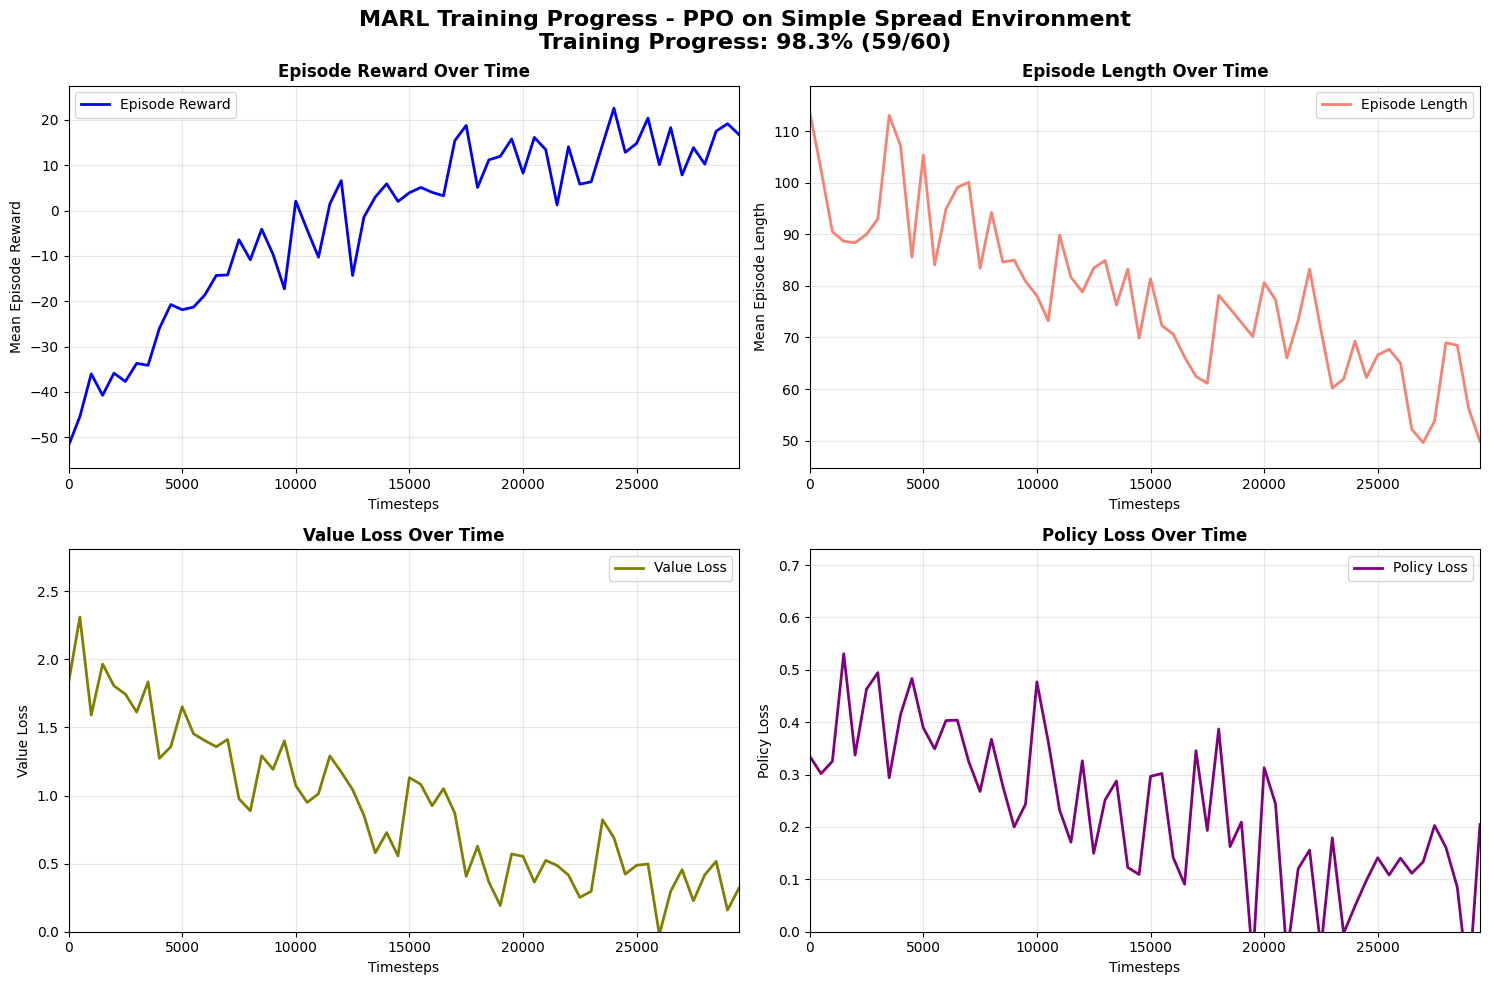

In [7]:
# visualize rewards, episode length, value loss and policu loss over time
gif_file = create_training_history_gif()

Saving individual PNG frames for dashboard...
Saved 50 PNG frames to latex/imgs/dashboard/


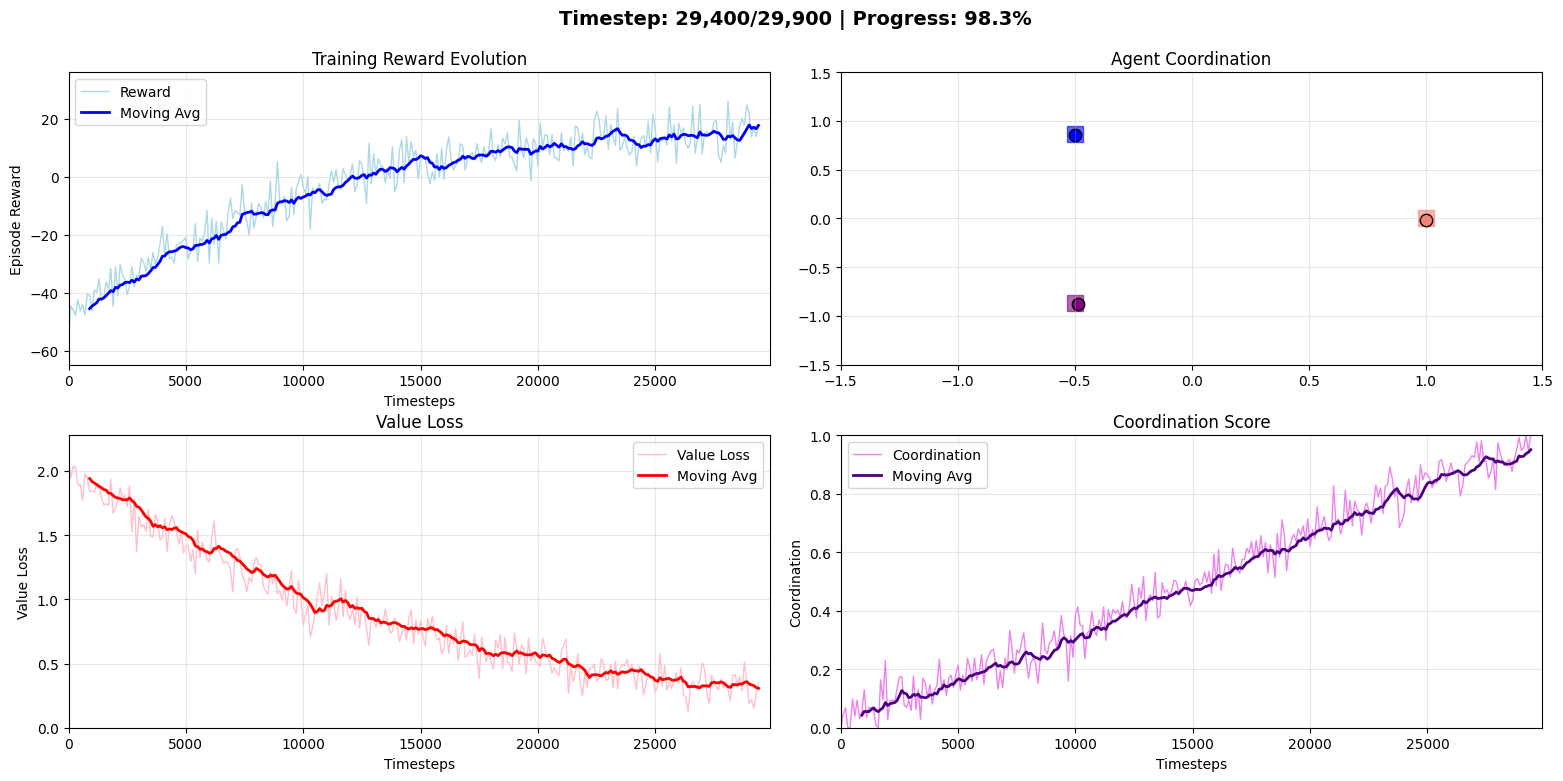

In [8]:
# visualize the evolution of rewards with moving avg, coordination score and movement of agents
create_training_dashboard_gif()

In [9]:
# Load the trained model
model = PPO.load("ppo_marl_simple_spread")

# Create a clean environment for testing (with rendering enabled)
test_env = simple_spread_v3.env(
    N=num_agents,
    local_ratio=0.5,
    max_cycles=100,
    continuous_actions=False,
    render_mode="human",
)
test_env = ss.black_death_v3(test_env)
test_env = ss.flatten_v0(test_env)
test_env = aec_to_parallel(test_env)
test_env = ss.pettingzoo_env_to_vec_env_v1(test_env)
test_env = ss.concat_vec_envs_v1(
    test_env, 1, num_cpus=1, base_class="stable_baselines3"
)

print("Testing trained agents...")
obs = test_env.reset()
for i in range(100):  # Run for 50 steps
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = test_env.step(action)
    test_env.render()  # This will show the visualization
    time.sleep(0.1)  # Slow down for better visualization

    if dones.all():
        obs = test_env.reset()
        print(f"Episode finished at step {i}")

test_env.close()

Testing trained agents...
